# Morning
# Introduction to Time Series Analysis
The simplest demonstration of temporal dependence is seen by considering a univariate time series $y(t)$. In our case, $y(t)$ may be the surface-level atmsopheric concentration of ozone at a single EPA air-quality station in Orange County. A plot of such observation may look as follows.

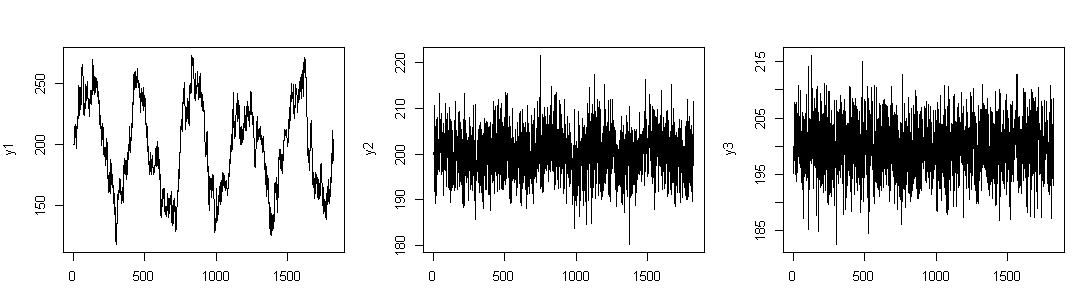

In [97]:
rm(list=ls())
T        <- 365*5 
ts       <- 1:T
y0       <- 10
a        <- 0.95
s        <- 5
y1=y2=y3 <- 200
b        <- (2*pi/365)
p        <- 2*sin(b*(1:T))

for(i in 2:T){
   y1tp1 <- y0    + a*y1[i-1] + p[i] + rnorm(1,0,s) 
   y2tp1 <- y2[1] +             p[i] + rnorm(1,0,s)   
   y3tp1 <- y3[1]                    + rnorm(1,0,s)
   y1    <- c(y1,y1tp1)
   y2    <- c(y2,y2tp1)
   y3    <- c(y3,y3tp1) 
}

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
plot(y1,type='l')
plot(y2,type='l')
plot(y3,type='l')

# Periodicity

Correlation of y1 with the seasonal period = 0.84901


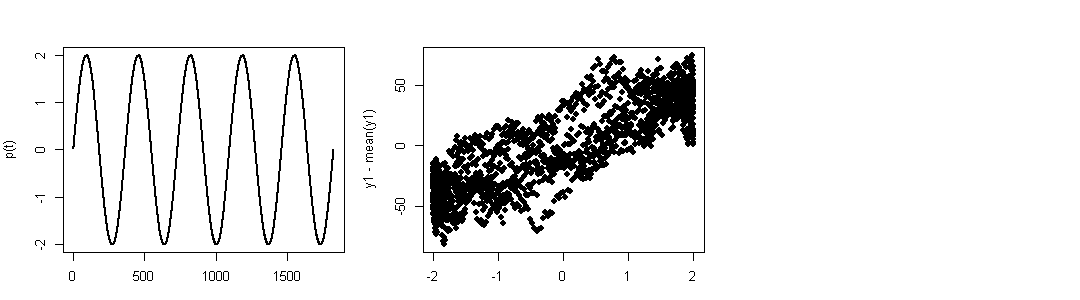

In [98]:
options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
plot(p,type='l',ylab='p(t)',lwd=2)
plot(p,y1-mean(y1),pch=19)
matrix(paste('Correlation of y1 with the seasonal period = ',round(cor(p,y1-mean(y1)),5)))

In [99]:
fity1 <- lm(y1 ~ sin(b*ts) + cos(b*ts)); summary(fity1)$coefficients[,1:2]
fity2 <- lm(y2 ~ sin(b*ts) + cos(b*ts)); summary(fity2)$coefficients[,1:2]
fity3 <- lm(y3 ~ sin(b*ts) + cos(b*ts)); summary(fity3)$coefficients[,1:2]

,Estimate,Std. Error
(Intercept),198.78988,0.376890
sin(b * ts),43.98733,0.533003
cos(b * ts),-15.22367,0.533003


,Estimate,Std. Error
(Intercept),200.15196647,0.1176583
sin(b * ts),1.74205342,0.1663940
cos(b * ts),0.04932066,0.1663940


,Estimate,Std. Error
(Intercept),199.84952092,0.1136783
sin(b * ts),0.04914628,0.1607654
cos(b * ts),-0.32267177,0.1607654


# The Autocorrelation/Autocovariance Function

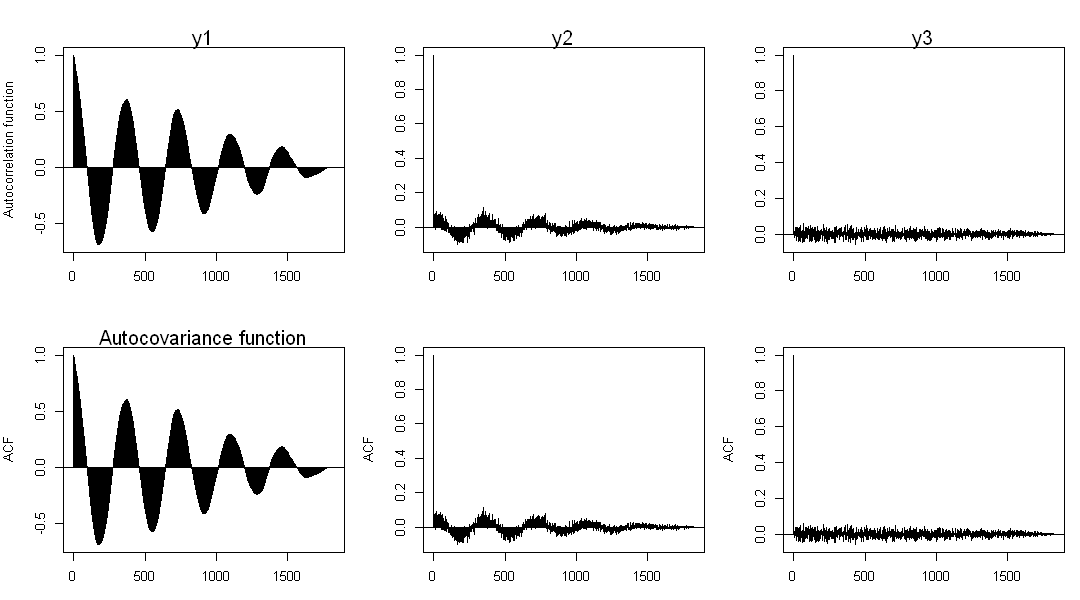

In [100]:
options(repr.plot.width=9, repr.plot.height=5)
par(mfrow=c(2,3),mar=c(3,4,3,1),cex.axis=0.95)
acf(y1,lag.max=T,main='',ci=0,ylab='Autocorrelation function'); mtext('y1')
acf(y2,lag.max=T,main='',ci=0,ylab=''); mtext('y2')
acf(y3,lag.max=T,main='',ci=0,ylab=''); mtext('y3')
acf(y1,lag.max=T,main='',ci=0); mtext('Autocovariance function')
acf(y2,lag.max=T,main='',ci=0); mtext('')
acf(y3,lag.max=T,main='',ci=0); mtext('')

 # Time Series Decomposition and Trend Analysis

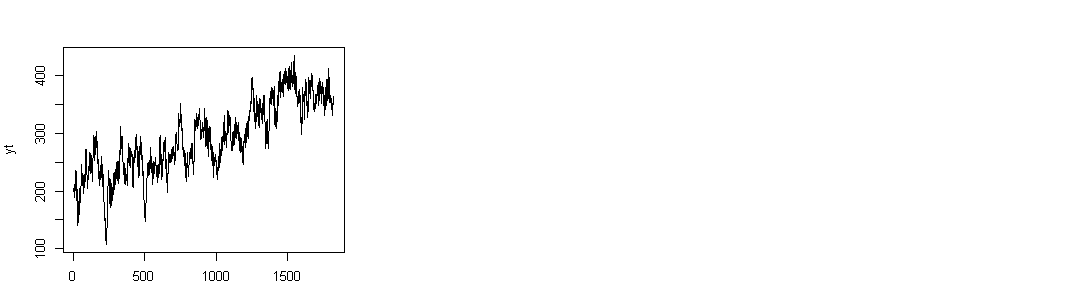

In [101]:
T  <- 365*5   #[days]
y0 <- 10      #[x/x]
a  <- 0.95
s  <- 10
yt <- 200
e  <- 0
b  <- (2*pi/365)
p  <- 2*sin(b*(1:T))
bt <- 0.1 

for(t in 2:T){
   etp1 <- a*e[t-1] + rnorm(1,0,s)
   ytp1 <- yt[1] + bt*t + p[t] + etp1  
   yt   <- c(yt,ytp1)
   e    <- c(e,etp1)
}

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
plot(yt,type='l')

,Estimate,Std. Error
(Intercept),197.1901356,1.479658112
ts,0.1028568,0.001408003
sin(b * ts),11.4173564,1.049037104


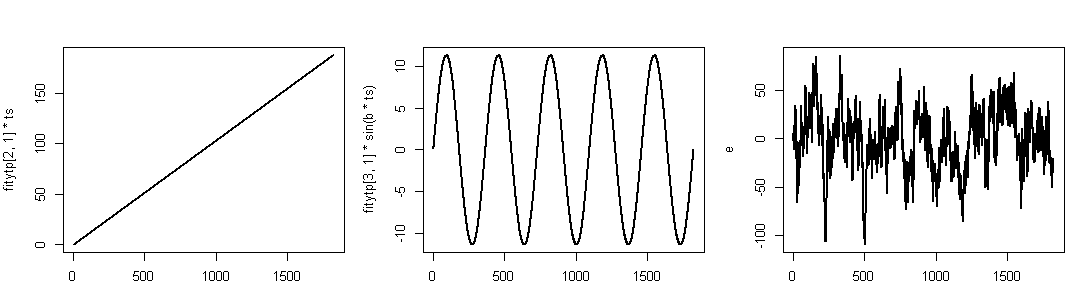

In [102]:
library(nlme)
w <- b*ts
fityt   <- lm(yt ~ ts + sin(b*ts)); fitytp  <- summary(fityt)$coefficients[,1:2]; fitytp
    e   <- residuals(fityt)[2:T]
options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
plot(fitytp[2,1]*ts,type='l',lwd=2)
plot(fitytp[3,1]*sin(b*ts),type='l',lwd=2)
plot(e,type='l',lwd=2)

In [110]:
options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
acf(e,lag.max=100,main='',ci=0)
plot(e[1:(t-1)],e[2:T],col='grey')
ereg <- lm(e[2:T] ~ e[1:(t-1)])
cor(e[2:T],e[1:(t-1)],na.rm=TRUE)

abline(ereg,lwd=2)
summary(ereg)$coefficients[,1:2] 
acf(e,lag.max=100,main='',ci=0)
lines(exp(-(1-0.94514)*seq(1,100)))

ERROR: Error in cor(e[2:T], e[1:(t - 1)], na.rm = TRUE): unused argument (na.rm = TRUE)


## Importance of Detrending

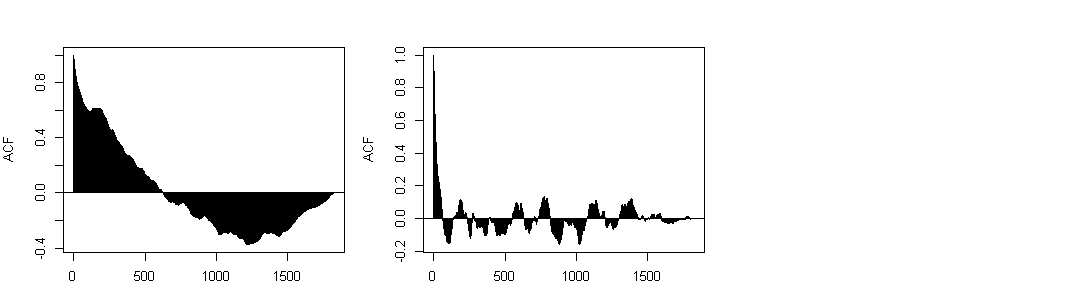

In [104]:
ytd <- yt - predict(lm(yt ~ ts))

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
acf(yt,lag.max=T,main='',ci=0)
acf(ytd,lag.max=T,main='',ci=0)

# Trend Analysis

,Estimate,Std. Error
(Intercept),197.1901356,1.479658112
ts,0.1028568,0.001408003
sin(b * ts),11.4173564,1.049037104


,Value,Std.Error
(Intercept),197.9684688,9.116992078
ts,0.1016824,0.008628337
sin(w),11.0823128,6.298420596


Phi estimate = 0.94858


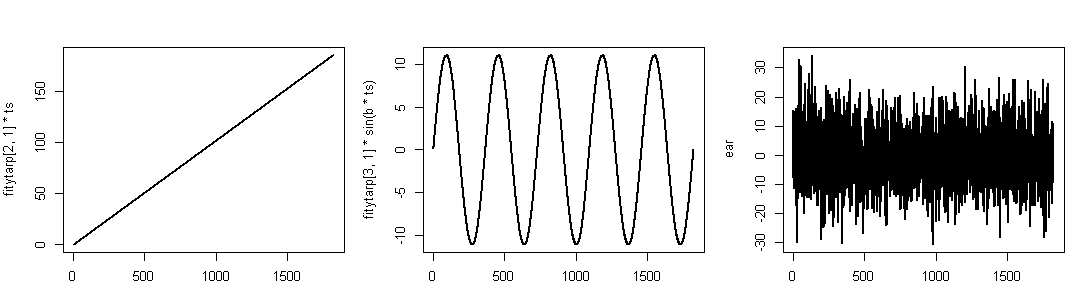

In [105]:
fitytar <- gls(yt  ~ ts + sin(w), correlation = corAR1()); fitytarp <- summary(fitytar)$tTable[,1:2]; fitytp; fitytarp
    ear <- as.numeric(residuals(fitytar)); ear <- ear[-1]
    phi <- as.numeric(coef(fitytar$modelStruct$corStruct,unconstrained=FALSE)); matrix(paste('Phi estimate = ',round(phi,5)))
    ear <- ear[2:T] - phi*ear[1:(T-1)]

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(3,4,3,1),cex.axis=0.95)
plot(fitytarp[2,1]*ts,type='l',lwd=2)
plot(fitytarp[3,1]*sin(b*ts),type='l',lwd=2)
plot(ear,type='l',lwd=2)